<a href="https://colab.research.google.com/github/mindyng/Projects/blob/master/LSTM_build_for_Short_Term_Household_Energy_Consumption_Prediction_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal: Predict Global_active_power at current time (t) given Household Energy Consumption using LSTM Network

## Difference between this version and v1 is that dataset will have one more variable and the LSTM architecture will be modified (epochs and batch sizes). Modifications will be done separately, not all at the same time to track progressive improvements hopefully.

Inspired by: https://www.kaggle.com/amirrezaeian/time-series-data-analysis-using-lstm-tutorial

## Import all needed packages.

In [1]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [14]:
#Read in power data

# df = pd.read_csv('/content/drive/My Drive/household_power_consumption.txt', sep=';', 
#                  parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
#                  low_memory=False, na_values=['nan','?'], index_col='dt')

df = pd.read_csv("/content/drive/My Drive/household_power_consumption.csv",index_col=[0], parse_dates=[0])

## EDA

In [15]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


We can see here in the dt column that the household consumption data is in minute increments.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
 7   sub_metering_4         float64
dtypes: float64(8)
memory usage: 142.5 MB


Pretty huge dataset: >2 million rows =) !

In [17]:
df.describe() #overall stat's

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00,9.314693e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00,9.585916e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-2.400000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.800000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.500000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,1.036667e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,1.248333e+02


## Imputing data

In [18]:
dropping_list_all = []
for j in range(0,8):
  if not df.iloc[:,j].notnull().all():
    dropping_list_all.append(j)
dropping_list_all

[0, 1, 2, 3, 4, 5, 6, 7]

In [19]:
#Impute NaN's with mean value from columns
for j in range(0,8):
  df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [20]:
#verifying no NaN's
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
sub_metering_4           0
dtype: int64

## Data Viz

### Below are a series of graphs that resample the time series data at varying levels of granularity and the various energy consumption data aggregated with mean() / sum().

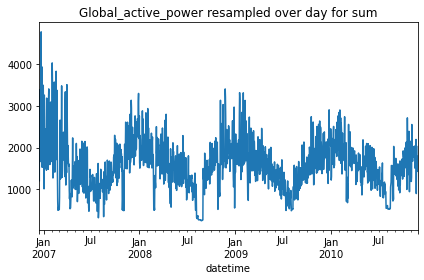

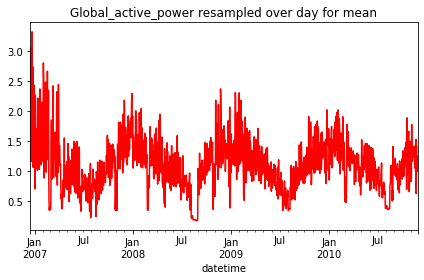

In [21]:
df.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for sum') 
plt.tight_layout()
plt.show()   

df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day for mean', color='red') 
plt.tight_layout()
plt.show()

We can see here that though time resampling is different between graphs, they have the same shape (seasonality).

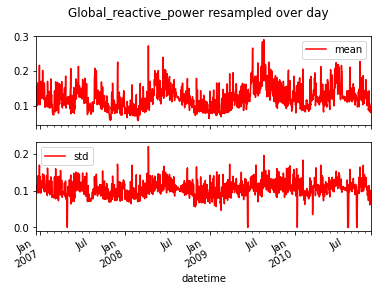

In [23]:
### Below I show mean and std of 'Global_reactive_power' resampled over day
r2 = df.Global_reactive_power.resample('D').agg(['mean', 'std'])
r2.plot(subplots = True, title='Global_reactive_power resampled over day', color='red')
plt.show()

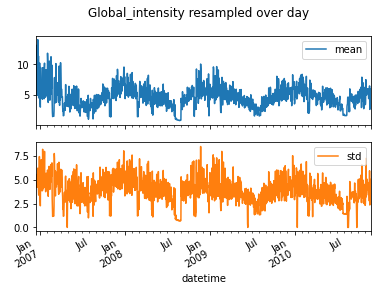

In [22]:
### Below I show mean and std of 'Global_intensity' resampled over day 
r = df.Global_intensity.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='Global_intensity resampled over day')
plt.show()

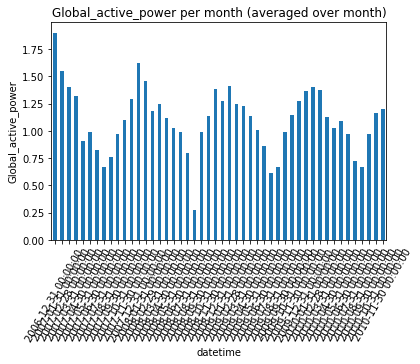

In [25]:
# Sum of 'Global_active_power' resampled over month
df['Global_active_power'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per month (averaged over month)')
plt.show()

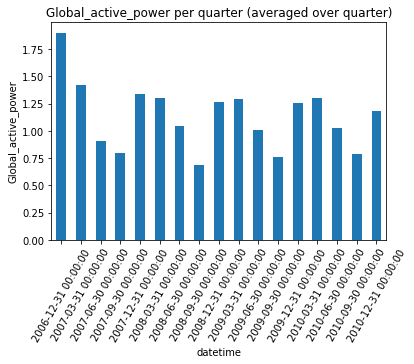

In [26]:
## Mean of 'Global_active_power' resampled over quarter
df['Global_active_power'].resample('Q').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per quarter (averaged over quarter)')
plt.show()

### Important reminder that whenever there are huge aggregations over time, the seasonality is reduced. This is important for ML feature engineering.

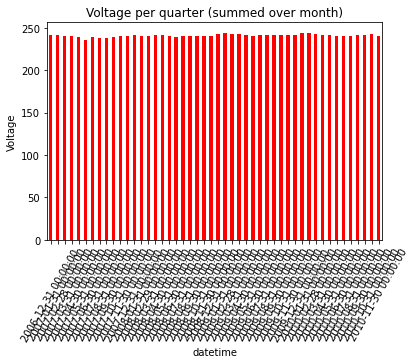

In [27]:
## mean of 'Voltage' resampled over month
df['Voltage'].resample('M').mean().plot(kind='bar', color='red')
plt.xticks(rotation=60)
plt.ylabel('Voltage')
plt.title('Voltage per quarter (summed over month)')
plt.show()

### Aggregation for Voltage is constant. This is important for feature selection since you want features with variance.


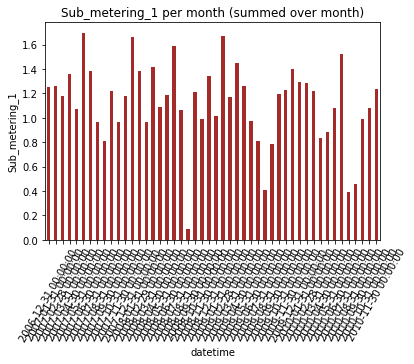

In [28]:
## mean of 'Sub_metering_1' resampled over month
df['Sub_metering_1'].resample('M').mean().plot(kind='bar', color='brown')
plt.xticks(rotation=60)
plt.ylabel('Sub_metering_1')
plt.title('Sub_metering_1 per month (summed over month)')
plt.show()

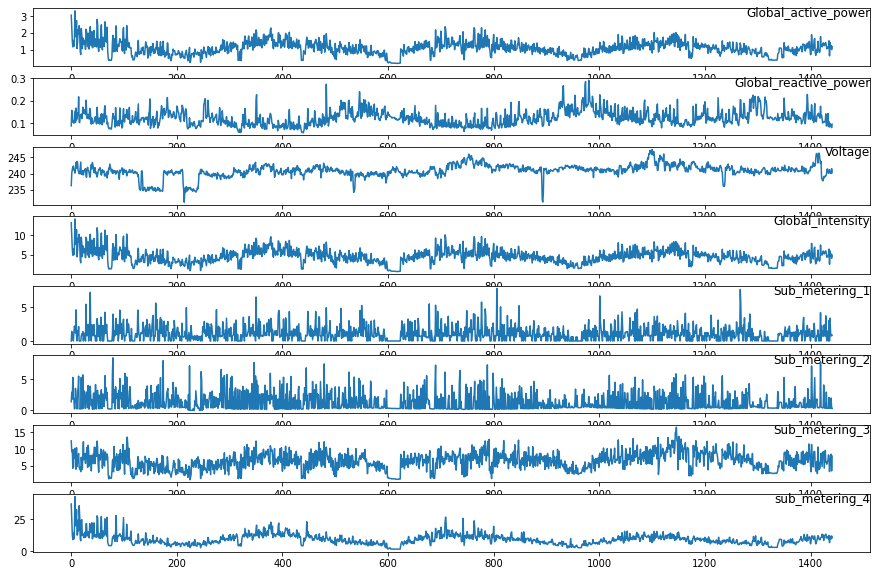

In [30]:
# Below I compare the means of different features resampled over day. 

cols = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
groups=cols
values = df.resample('D').mean().values
# plot each column
plt.figure(figsize=(15, 10))
for group in groups:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.75, loc='right')
	i += 1
plt.show()

This is a nice view of how each variable has its own cyclical behavior, plateau and outliers.

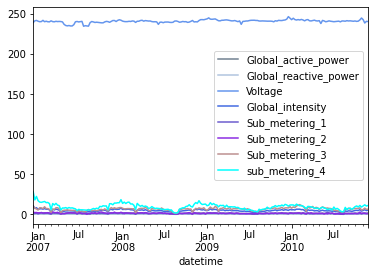

In [31]:
## Different features' means resampled over week.
df.Global_active_power.resample('W').mean().plot(color='slategrey', legend=True)
df.Global_reactive_power.resample('W').mean().plot(color='lightsteelblue', legend=True)
df.Voltage.resample('W').mean().plot(color='cornflowerblue', legend=True)
df.Global_intensity.resample('W').mean().plot(color='royalblue', legend=True)
df.Sub_metering_1.resample('W').mean().plot(color='slateblue', legend=True)
df.Sub_metering_2.resample('W').mean().plot(color='blueviolet', legend=True)
df.Sub_metering_3.resample('W').mean().plot(color='rosybrown', legend=True)
df.sub_metering_4.resample('W').mean().plot(color='cyan', legend=True)
plt.show()

## Voltage has highest readings whereas Global reactive power has the lowest readings.

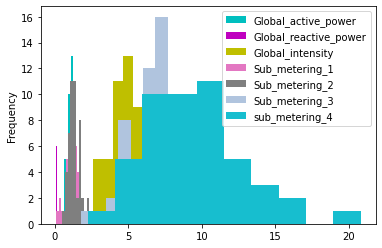

In [32]:
# Different features' mean resampled over month.
df.Global_active_power.resample('M').mean().plot(kind='hist', color='c', legend=True )
df.Global_reactive_power.resample('M').mean().plot(kind='hist',color='m', legend=True)
#df.Voltage.resample('M').mean().plot(kind='hist',color='y', legend=True)
df.Global_intensity.resample('M').mean().plot(kind='hist', color='y', legend=True)
df.Sub_metering_1.resample('M').mean().plot(kind='hist', color='tab:pink', legend=True)
df.Sub_metering_2.resample('M').mean().plot(kind='hist', color='tab:gray', legend=True)
df.Sub_metering_3.resample('M').mean().plot(kind='hist', color='lightsteelblue', legend=True)
df.sub_metering_4.resample('M').mean().plot(kind='hist', color='tab:cyan', legend=True)
plt.show()

Global active power is ahead (after taking Voltage out [need to normalize data]) with Sub_metering_3 and Global_intensity not far behind.

## Now onto **correlations** which is a great way to see any relationships between features.

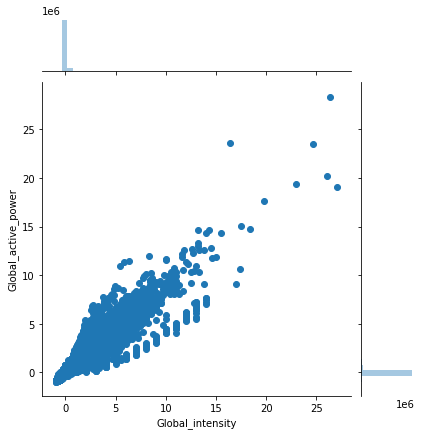

In [33]:
## The correlations between 'Global_intensity', 'Global_active_power'
data_returns = df.pct_change()
sns.jointplot(x='Global_intensity', y='Global_active_power', data=data_returns)  

plt.show()

There is a pretty strong relationship between Global intensity and Global active power.

(pearsonr = 0.94)


Now let us take a look at the relationship between Global active power and Voltage.

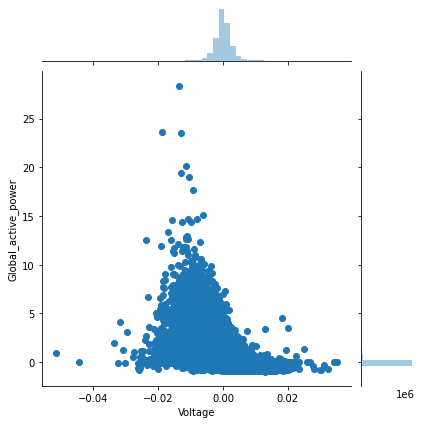

In [34]:
## The correlations between 'Voltage' and 'Global_active_power'
data_returns = df.pct_change()
sns.jointplot(x='Voltage', y='Global_active_power', data=data_returns)  

plt.show()

We can see here that the relationship is not strong at all. 

(pearsonr = -0.3)

Let us further our investigation into relationships between features by looking at some heatmaps.

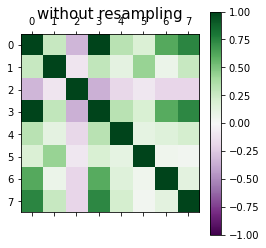

In [35]:
# Correlations among columns (raw/no aggregations)
plt.matshow(df.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('without resampling', size=15)
plt.colorbar()
plt.show()

Variables as is with data represented at minute level.
We can see here that along with the diagonal, only other strong relationship is between features 0 and 3.

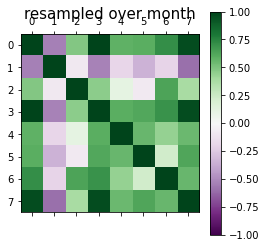

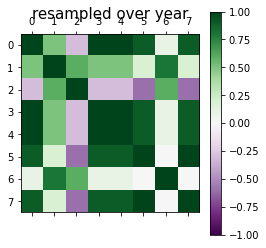

In [36]:
# Correlations of features' means resampled over months and year.

plt.matshow(df.resample('M').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over month', size=15)
plt.colorbar()
plt.margins(0.02)
plt.matshow(df.resample('A').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over year', size=15)
plt.colorbar()
plt.show()


Look at how correlations between features change once we aggregated data differently over time! There is a huge jump in strong relationships when time series is aggregated over year. This makes sense since there is less variance between features after that sort of transformation. This correlation change is important to note for feature engineering.

## LSTM Data Prep and Feature Engineering

For this problem, since it is a time series problem with sequential data and a lot of it, we will be applying a recurrent neural network (LSTM).

To reduce computation time, aggregating min data to hr format.

In [ ]:
#To reduce computation time, aggregating min data to hr format.

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


After calling this function, the data will be formatted as needed to feed into model.

In [ ]:
## resampling of data over hour
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

Size of data went from 2075259 to 34589 samples.

In [ ]:
## Note: I scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then used below
values = df_resample.values 


## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var6(t-1)  var7(t-1)   var1(t)
1   0.636816   0.295738   0.337945  ...   0.011366   0.782418  0.545045
2   0.545045   0.103358   0.335501  ...   0.144652   0.782676  0.509006
3   0.509006   0.110073   0.283802  ...   0.030869   0.774169  0.488550
4   0.488550   0.096987   0.315987  ...   0.000000   0.778809  0.455597
5   0.455597   0.099010   0.434417  ...   0.008973   0.798917  0.322555

[5 rows x 8 columns]


Above I showed 7 input variables (input series) and the 1 output variable for 'Global_active_power' at the current time in hour (depending on resampling).

Splitting the rest of the data to train and validation sets.


To further speed of computation time, training data only on 1st year and test on subsequent 3 years.

In [ ]:
# split into train and test sets
values = reframed.values

n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(8760, 1, 7) (8760,) (25828, 1, 7) (25828,)


## LSTM Model architecture

1) LSTM with 100 neurons in the first visible layer

3) dropout 20%

4) 1 neuron in the output layer for predicting Global_active_power.

5) The input shape will be 1 time step with 7 features.

6) I use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

7) The model will be fit for 20 training epochs with a batch size of 70.

Train on 8760 samples, validate on 25828 samples
Epoch 1/20
 - 2s - loss: 0.0199 - val_loss: 0.0120
Epoch 2/20
 - 1s - loss: 0.0127 - val_loss: 0.0106
Epoch 3/20
 - 1s - loss: 0.0115 - val_loss: 0.0097
Epoch 4/20
 - 1s - loss: 0.0108 - val_loss: 0.0092
Epoch 5/20
 - 1s - loss: 0.0107 - val_loss: 0.0092
Epoch 6/20
 - 1s - loss: 0.0106 - val_loss: 0.0092
Epoch 7/20
 - 1s - loss: 0.0105 - val_loss: 0.0092
Epoch 8/20
 - 1s - loss: 0.0106 - val_loss: 0.0092
Epoch 9/20
 - 1s - loss: 0.0105 - val_loss: 0.0092
Epoch 10/20
 - 1s - loss: 0.0105 - val_loss: 0.0092
Epoch 11/20
 - 1s - loss: 0.0104 - val_loss: 0.0093
Epoch 12/20
 - 1s - loss: 0.0104 - val_loss: 0.0093
Epoch 13/20
 - 1s - loss: 0.0104 - val_loss: 0.0092
Epoch 14/20
 - 1s - loss: 0.0104 - val_loss: 0.0092
Epoch 15/20
 - 1s - loss: 0.0104 - val_loss: 0.0093
Epoch 16/20
 - 1s - loss: 0.0104 - val_loss: 0.0093
Epoch 17/20
 - 1s - loss: 0.0104 - val_loss: 0.0092
Epoch 18/20
 - 1s - loss: 0.0103 - val_loss: 0.0092
Epoch 19/20
 - 1s - loss

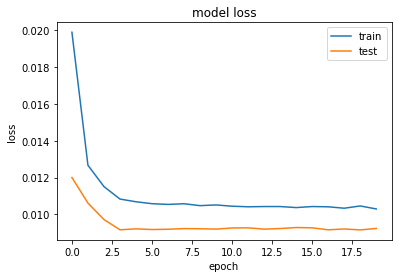

Test RMSE: 0.618


In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In order to improve the model, need to adjust batch size and epoch's.

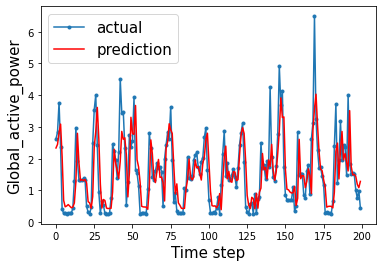

In [ ]:
## time steps: every step is one hour (you can easily convert the time step to the actual time index (min))
## for a demonstration purpose, I only compare predictions in 200 hours. 

aa=[x for x in range(200)]
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

Final remarks:

* Here we have used an LSTM neural network which is state-of-the-art model for sequential problems.

* In order to reduce the computation time and get some results quickly, we resampled to hour granularity and took the first year of data to train the model. The rest of the data was used to test the model (3 years).

* We put together a very simple LSTM neural-network to show that one can obtain reasonable predictions (need to compare to baseline model (SARIMAX). Amount of data to compute is still high and as a result the computation could be very time-consuming (though using Colab with TPU's, run time was in seconds). The best resources/method to use is to write the last part of code using Spark (MLlib) running on GPU.

* The neural-network architecture that we have designed is a toy model. It can be easily improved by adding CNN and dropout layers. The CNN is useful here since there are correlations in data (CNN layer is a good way to probe the local structure of data).